C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import 2013 Bike Sharing data
    tractID  jday        hr  holiday  workingday  atemp  humidity  windspeed  \
0  0.008929     1 -2.245598        1           0    0.4  4.234107   2.493205   
1  0.062500     1 -2.245598        1           0    0.4  4.234107   2.493205   
2  0.133929     1 -2.245598        1           0    0.4  4.234107   2.493205   
3  0.142857     1 -2.245598        1           0    0.4  4.234107   2.493205   
4  0.160714     1 -2.245598        1           0    0.4  4.234107   2.493205   

   casual  registered   ...    mth_2  mth_3  mth_4  mth_5  mth_6  mth_7  \
0     0.0    0.693147   ...      0.0    0.0    0.0    0.0    0.0    0.0   
1     0.0    0.693147   ...      0.0    0.0    0.0    0.0    0.0    0.0   
2     0.0    0.693147   ...      0.0    0.0    0.0    0.0    0.0    0.0   
3     0.0    0.693147   ...      0.0    0.0    0.0    0.0    0.0    0.0   
4     0.0    1.098612   ...      0.0    0.0    0.0    0.0    0.0    0.0   

   mth_8  mth_9  mth_10  mth_11  
0   

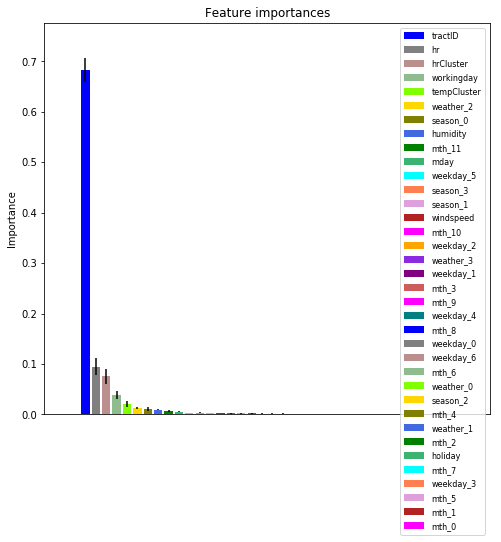

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\incremental_pca.py:271: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from scipy import sparse 
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from matplotlib import cm

import sklearn.cluster as cluster
import statsmodels.api as sm

import pandas as pd
import numpy as np
import datetime as dt
from math import *


# =====================================================================

ifile = "D:/Capston/2013_Hour_By_Tract.csv"
pngfile = "D:/Capston/Features_Importance"

#features = ['tractID','hr','yr','jday','mday','mth','mthCluster','hrCluster','tempCluster','weekday','holiday','workingday','season','temp','weather','season_0','season_1','season_2','season_3','humidity','windspeed']
#features = ['tractID','jday','mday','mthCluster','hrCluster','tempCluster','weekday','workingday','weather','season_0','season_1','season_2','season_3','humidity','windspeed']
#features = ['tractID','hr','yr','jday','mday','mth','weekday','holiday','workingday','season','temp','weather','humidity','windspeed']
features=['tractID','mday','hr','tempCluster','hrCluster',
          'season_0','season_1','season_2','season_3',
          'weather_0','weather_1','weather_2','weather_3',
          'weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6',
          'mth_0','mth_1','mth_2','mth_3','mth_4','mth_5','mth_6','mth_7','mth_8','mth_9','mth_10','mth_11',
          'holiday','workingday', 'windspeed','humidity']

colors = ['blue','grey','rosybrown','darkseagreen','chartreuse','gold','olive','royalblue',
          'green','mediumseagreen','aqua','coral','plum','firebrick','fuchsia','orange',
          'blueviolet','purple','indianred','magenta','teal']
# =====================================================================

def read_data():
    ds = pd.read_csv(ifile, sep=',', header=0)
    ds['dteday'] = pd.to_datetime(ds['dteday'], format='%Y-%m-%d')
    ds['mday'] = ds['dteday'].dt.day 
    
    return remove_columns(ds, ['dteday', 'yr'])                        


def remove_columns(ds, drop_cols):
    ds = ds.drop(drop_cols, axis = 1)

    return ds

# =====================================================================

def split_list(alist, wanted_parts = 1):
    length = len(alist)
    return [ alist[i * length // wanted_parts: (i + 1) * length // wanted_parts]
            for i in range(wanted_parts) ]


def data_cluster(df, grpBy, cluster_num):
    
    cluster_data = df.groupby([grpBy]).agg(lambda x: x.mean())[['cnt']]
    model = cluster.KMeans(n_clusters = cluster_num)
    
    return np.array(model.fit_predict(split_list(cluster_data.iloc[:,0].values, len(cluster_data))))


def temp_cluster(temp):

    if temp <= 1.0: 
        return 0
    elif temp > 1.0 and temp <= 15:
        return 1
    elif temp > 15 and temp <= 22:
        return 2
    elif temp > 22 and temp <= 31:
        return 3
    else:
        return 4


def hr_cluster(hr):

    if hr <= 6.5: 
        return 0
    elif hr > 6.5 and hr <= 9.5:
        return 2
    elif hr > 9.5 and hr <= 16.5:
        return 1
    elif hr > 16.5 and hr <= 20:
        return 2
    else:
        return 0
     

def mth_cluster(mth):
    
    if mth <= 2 or mth == 12:
        return 0
    elif mth == 3 or mth == 11:
        return 1
    elif mth == 10:
        return 2
    else:
        return 3

def transform1_data(ds):
    
    ds['hrCluster'] = ds.apply(lambda x: hr_cluster(x['hr']), axis = 1) 
    ds['tempCluster'] = ds.apply(lambda x: temp_cluster(x['temp']), axis = 1) 

    enc = OneHotEncoder(sparse=False)  
    n = ds['season'].shape[0]
    enc_array = pd.DataFrame(sparse.csr_matrix(enc.fit_transform(ds['season'].values.reshape(-1, 1))).todense().reshape(n, 1, 4))
    ds['season_0'] = enc_array[[0]]
    ds['season_1'] = enc_array[[1]] 
    ds['season_2'] = enc_array[[2]] 
    ds['season_3'] = enc_array[[3]]     

    enc_array = pd.DataFrame(sparse.csr_matrix(enc.fit_transform(ds['weather'].values.reshape(-1, 1))).todense().reshape(n, 1, 4))
    ds['weather_0'] = enc_array[[0]]
    ds['weather_1'] = enc_array[[1]] 
    ds['weather_2'] = enc_array[[2]] 
    ds['weather_3'] = enc_array[[3]]     

    enc_array = pd.DataFrame(sparse.csr_matrix(enc.fit_transform(ds['weekday'].values.reshape(-1, 1))).todense().reshape(n, 1, 7))
    ds['weekday_0'] = enc_array[[0]]
    ds['weekday_1'] = enc_array[[1]] 
    ds['weekday_2'] = enc_array[[2]] 
    ds['weekday_3'] = enc_array[[3]]     
    ds['weekday_4'] = enc_array[[4]]
    ds['weekday_5'] = enc_array[[5]] 
    ds['weekday_6'] = enc_array[[6]] 
    
    enc_array = pd.DataFrame(sparse.csr_matrix(enc.fit_transform(ds['mth'].values.reshape(-1, 1))).todense().reshape(n, 1, 12))
    ds['mth_0'] = enc_array[[0]]
    ds['mth_1'] = enc_array[[1]] 
    ds['mth_2'] = enc_array[[2]] 
    ds['mth_3'] = enc_array[[3]]     
    ds['mth_4'] = enc_array[[4]]
    ds['mth_5'] = enc_array[[5]] 
    ds['mth_6'] = enc_array[[6]] 
    ds['mth_7'] = enc_array[[7]]
    ds['mth_8'] = enc_array[[8]] 
    ds['mth_9'] = enc_array[[9]] 
    ds['mth_10'] = enc_array[[10]]     
    ds['mth_11'] = enc_array[[11]]   

    return remove_columns(ds, ['season', 'weather', 'weekday', 'mth', 'temp'])
                        

def transform2_data(df):
        
    df['casual'] = [log1p(x) for x in df['casual']]
    df['registered'] = [log1p(x) for x in df['registered']]
    df['cnt'] = [log1p(x) for x in df['cnt']]

    df['tractID'] = MinMaxScaler().fit_transform(df['tractID'].astype(float).values.reshape(-1, 1))
    df['hr'] = StandardScaler().fit_transform(df['hr'].astype(float).values.reshape(-1, 1))
    #df['weekday'] = StandardScaler().fit_transform(df['weekday'].astype(float).values.reshape(-1, 1))
    #df['weather'] = StandardScaler().fit_transform(df['weather'].astype(float).values.reshape(-1, 1))
    #df['temp'] = StandardScaler().fit_transform(df['temp'].values.reshape(-1, 1))
    #df['jday'] = StandardScaler().fit_transform(df['jday'].astype(float).values.reshape(-1, 1))
    df['mday'] = StandardScaler().fit_transform(df['mday'].astype(float).values.reshape(-1, 1))
    #df['mth'] = StandardScaler().fit_transform(df['mth'].astype(float).values.reshape(-1, 1))
    #df['season'] = StandardScaler().fit_transform(df['season'].astype(float).values.reshape(-1, 1))    
    df['windspeed'] = [log1p(x) for x in df['windspeed']]
    df['humidity'] = [log1p(x) for x in df['humidity']]
    

    print(df.head())
    return df



# =====================================================================


def features_importance(model, pngfile):
    X_data, y_data = bike[features], bike[['cnt']]

    model.fit(X_data, y_data.values.ravel())
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
    indices = np.argsort(importances)[::-1]
    labels = np.array(X_data.columns.values)
    print("Feature ranking:")

    fig, ax = plt.subplots(figsize = (8, 8))
    fi = ax.bar(range(X_data.shape[1]), importances[indices],
                color=colors, yerr=std[indices], align="center")
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title('Feature importances')
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_visible(False)
    #ax.set_xticklabels(labels[indices], rotation = 'vertical', 
    #                   fontsize=7, minor = False)
    plt.margins(0.1)
    plt.subplots_adjust(bottom=0.2)

    legend = ax.legend(fi, labels[indices], loc = 1)
    frame = legend.get_frame()
    for label in legend.get_texts():
        label.set_fontsize(8)

    plt.savefig(pngfile)
    plt.show()

# =====================================================================

print("Import 2013 Bike Sharing data")
bike = read_data()
bike = transform1_data(bike)
bike = transform2_data(bike)
bike = remove_columns(bike, ['registered','casual'])

X_data, y_data = bike[features], bike[['cnt']]

# Feacture importances
print("Features Importnce...")

model = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto',
                            max_depth = 28, min_samples_split = 45,
                            random_state = 0)
features_importance(model, pngfile + "ExtraTrees.png")

X = X_data.values
y = y_data.values.ravel()

n_component = 10
ipca = IncrementalPCA(n_components=n_component,batch_size=10)
X_ipca = ipca.fit_transform(X)

"""
print("Components with maximum variance")
print(ipca.components_)
print("Variance explained by each of the selected components")
print(ipca.explained_variance_ratio_)
print("Percentage of variance explained by each of the selected components")
print(ipca.explained_variance_)
print("Singular values corresponding to each of the selected components")
print(ipca.singular_values_)
"""                        
                        
pca = PCA(n_components=n_component)
X_pca = pca.fit_transform(X)

colors = ['orange','forestgreen','blue']

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8,8))
    for color, i, target_name in zip(colors, [0, 1, 2], 'cnt'):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                   color=color, lw=2, label=target_name)
        
        if "Incremental" in title:
            err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
            plt.title(title + " of Bike sharing 2013\n Mean absolute unsigned error "
                     "%.6f" % err)
        else:
            plt.title(title + " of Bike sharing 2013")
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.axis([-4, 4, -1.5, 1.5])


   
    




